# Introdução

O nosso objetivo para escolher o dataset era avaliar as notas e desempenho dos alunos com base em variáveis sociais / de estudo, sem considerar questões socioeconômicas. Sobre aplicações sociais, pensamos em como seria importante acompanhar o aluno durante o tempo anterior à prova, fazendo questionários antes, ir trabalhando nos pontos fracos do aluno e melhorar o desempenho geral do ensino nas escolas municipais com base nas respostas dadas pelo aluno. Esse estudo promove a ideia de que o desempenho do aluno poderia ser "previsto", mesmo se o questionário fosse respondido meses antes da prova em si, o que trás um alarme para como a qualidade de ensino deve ser melhorada, mas o aluno também pode ter melhores resultados, caso tenha um acompanhamento considerando essas variáveis.

# Descrição do Dataset

O Sistema de Avaliação da Educação Básica (Saeb) é um conjunto de avaliações externas em larga escala que permite ao Inep realizar um diagnóstico da educação básica brasileira e de fatores que podem interferir no desempenho do estudante. Desde 1995, a avaliação bienal busca fornecer um panorama da Educação Básica e sofreu algumas mudanças metodológicas para aprimoramento. Juntamente com outros indicadores, as notas do SAEB estruturam a nota do Índice de Desenvolvimento da Educação Básica (Ideb). Por meio de testes e questionários, aplicados a cada dois anos na rede pública e em uma amostra da rede privada, o Saeb reflete os níveis de aprendizagem demonstrados pelos estudantes avaliados, explicando esses resultados a partir de uma série de informações contextuais. Avalia as séries: 5º ano, 9º ano e 3º ano do EM. Em 2019, tem o 2º ano do E.F.

# Tratamento / Análise de Dados

Após a escolha do Dataset, disponível em [Base dos Dados - SAEB](https://basedosdados.org/dataset/e083c9a2-1cee-4342-bedc-535cbad6f3cd?table=d429a79a-eca1-461c-9c1f-ce65d61048a1), precisamos fazer o tratamento dos dados, tratamento das colunas, análise das correlações / feature engineering e análise dos dados, tudo para que tivéssemos os dados da melhor forma possível. Os notebooks estão separados em ordem, visando a [Reproducible Research](https://book.the-turing-way.org/reproducible-research/reproducible-research). Considerados como códigos-fonte a parte do projeto principal, eles estão separados na pasta `treatment_analysis/` da forma:

1. initial-treatment.ipynb: Contém o tratamento inicial, a lógica para juntar os dados de 2007 até 2017 (considerando que as provas são realizadas a cada 2 anos) e tratamentos básicos como preencher idades faltantes e remover questionários nao preenchidos;
2. columns-treatment.ipynb: Contém a transformação das colunas do dataset (com base no dicionário das perguntas) pra valores discretos, de forma ordinal. Também são retiradas colunas não consideradas para o estudo e remoção de outliers com base na proficiencia / erro_padrao;
3. correlation_featureengineering.ipynb: Contém a análise das correlações entre as variáveis / features a partir de heatmaps e remoção de colunas com baixa ou nenhuma correlação com o desempenho do aluno. O dataset utilizado para treinar os modelos também é salvo desse notebook;
4. data-analysis.ipynb: Contém a análise dos dados, com foco na distribuição das classes com base na proficiência e erro padrão do aluno e a aplicação de PCA para relacionar as variáveis entre si.
5. data-interpos.ipynb: Contém a análise e a remoção de interposição (ruído) nos dados, através de força bruta analisando todas as possibilidades, balanceando os grupos. Também é feita a remoção da classe 'Proficiente', e ao mesmo tempo a junção das classes 'Insuficiente' e 'Básico'.


# 1. Tratamento de Dados Básico

In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score, KFold

from IPython.display import clear_output

clear_output()

cwd = os.getcwd()

ROOT = os.path.join(cwd)
DATA_FOLDER = os.path.join(ROOT, 'data/')

In [3]:
colab = False
if colab:
    df = pd.read_pickle('saeb_pb_2017-2007_fe_balanced.pkl')
else:
    df = pd.read_pickle(os.path.join(DATA_FOLDER, 'saeb_pb_2017-2007_fe_balanced.pkl'))
df = df.dropna()
df.head()

,id_aluno,faz_licao_casa_2.0,reprovacao_0.0,reprovacao_1.0,pai_sabe_ler_escrever_1.0,leitura_revista_comportamento_0.0,leitura_jornais_0.0,escolaridade_pai_4.0,mae_sabe_ler_escrever_1.0,leitura_internet_2.0,tempo_lazer_1.0,escolaridade_mae_4.0,gosta_estudar_disciplina_0.0,gosta_estudar_disciplina_1.0,desempenho_aluno_cat
38709,17486608,True,False,True,False,False,False,False,False,False,False,False,True,False,0
102980,11168544,True,False,True,False,False,False,False,True,False,True,False,False,True,0
55216,3272843,False,True,False,False,False,False,False,True,True,False,True,False,True,0
57311,12149602,False,False,True,False,False,False,False,True,True,False,True,True,False,0
38264,12094178,False,False,False,False,False,False,False,False,False,True,False,True,False,0


In [4]:
# colunas a serem excluidas (não serão consideradas como features em X)
exclude = ['ano', 'sigla_uf', 'id_aluno', 'situacao_censo', 'disciplina', 'proficiencia', 'erro_padrao', 'proficiencia_saeb',
       'erro_padrao_saeb', 'sexo', 'raca_cor','ano_nascimento', 'rede', 'id_escola', 'serie', 'turno', 'escola_publica', 'desempenho_aluno']

exclude = [col for col in df.columns if col in exclude]

In [5]:
# print unique values for each column

for col in df.columns:
    if col not in exclude:
        print(col, df[col].unique())

faz_licao_casa_2.0 [ True False]
reprovacao_0.0 [False  True]
reprovacao_1.0 [ True False]
pai_sabe_ler_escrever_1.0 [False  True]
leitura_revista_comportamento_0.0 [False  True]
leitura_jornais_0.0 [False  True]
escolaridade_pai_4.0 [False  True]
mae_sabe_ler_escrever_1.0 [False  True]
leitura_internet_2.0 [False  True]
tempo_lazer_1.0 [False  True]
escolaridade_mae_4.0 [False  True]
gosta_estudar_disciplina_0.0 [ True False]
gosta_estudar_disciplina_1.0 [False  True]
desempenho_aluno_cat [0 1]


Tratar os dados e construir a matriz $X$ e o vetor $y$ de entrada para o classificador;

In [6]:
df['desempenho_aluno_cat'].value_counts()

desempenho_aluno_cat
0    929
1    244
Name: count, dtype: int64

In [7]:
X = df.drop(columns=exclude + ['desempenho_aluno_cat'])
y = df['desempenho_aluno_cat']

X = X.astype('float32')
y = y.astype('float32')

Identificar o número de exemplos ($N$) e número de features;

In [8]:
N = len(X) # número de exemplos
n_features = X.shape[1] # número de features

print('Número de exemplos:', N)
print('Número de features:', n_features)

Número de exemplos: 1173
Número de features: 13


Separar os dados (𝑋,𝑦) entre treinamento e teste, justificando a quantidade de exemplos de cada grupo de dados. Não mexer no teste até a fase final de computação das métricas de aprendizado;

In [9]:
# separando em 20% para teste e 80% para treino
# por ser o valor mais comum
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# agora, separando os dados de treino em 20% para validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print('Número de exemplos de treino:', len(X_train))
print('Número de exemplos de validação:', len(X_val))
print('Número de exemplos de teste:', len(X_test))

Número de exemplos de treino: 750
Número de exemplos de validação: 188
Número de exemplos de teste: 235


Aplicar normalização ou padronização dos dados, justificando a escolha do método.

In [10]:
# não precisaremos aplicar normalização ou padronização nos dados,
# pois são de origem binária para todas as colunas, isto é, vão de 0 a 1.
# esse tratamento foi feito na etapa de feature engineering

# 2. Implementação do modelo baseado em Rede Neural

Definir a arquitetura da rede neural (número de camadas e o número de neurônios por camada) a partir do número de exemplos disponíveis no dataset e da “Regra de Ouro”, que é consequência da Teoria da Generalização do Aprendizado. Use o cálculo da dimensão VC para justificar a escolha da arquitetura mencionada. Obs: Não esqueça da existência do bias em cada neurônio e use o Teorema da Aproximação Universal;

In [11]:
def num_neurons(n_examples, n_features):
    return int((n_examples - 10) / (10 * (n_features + 2) ))

In [14]:
# usando uma camada oculta
print(X_train.shape)

print('De acordo com a regra de ouro da dimensão VC, \no número de neurônios na camada única oculta da Rede Neural \ndeve ser menor ou igual que')
print('----> ' + str(num_neurons(N, n_features)))

(750, 13)
De acordo com a regra de ouro da dimensão VC, 
o número de neurônios na camada única oculta da Rede Neural 
deve ser menor ou igual que
----> 7


Vamos inicializar um modelo sequencial com as escolhas de hiperparâmetros:
- função de ativação 'ReLU': É uma função com custo computacional mais baixo do que 'tanh', o que acaba deixando o treinamento mais rápido.
- Dropout: Visando não deixar o modelo com baixa capacidade de aprendizado, foi adicionado mais parâmetros do que o recomendado (mín. 75), e com isso foi necessário adicionar Dropout para regularizar e prevenir overfitting.
- Função de ativação 'sigmoid': É a função de ativação utilizada para classificação binária.
- Função de perda 'binary_crossentropy': É a função de perda utilizada para classificação binária.

In [16]:
model = Sequential()

model.add(Dense(7, input_dim=X_train.shape[1], activation='relu', kernel_regularizer='l2'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

# não precisamos utilizar early stopping o modelo é de baixa complexidade
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Compilar o modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 7)              │            98 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106 (424.00 B)

 Trainable params: 106 (424.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=12)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7211 - loss: 0.7688 - val_accuracy: 0.8404 - val_loss: 0.6995
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7586 - loss: 0.6974 - val_accuracy: 0.8404 - val_loss: 0.6117
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7472 - loss: 0.6392 - val_accuracy: 0.8404 - val_loss: 0.5445
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7832 - loss: 0.5721 - val_accuracy: 0.8404 - val_loss: 0.4981
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7591 - loss: 0.5566 - val_accuracy: 0.8404 - val_loss: 0.4698
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7813 - loss: 0.5091 - val_accuracy: 0.8404 - val_loss: 0.4422
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7469 - loss: 0.5146 - val_accuracy: 0.8404 - val_loss: 0.4167
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7522 - loss: 0.4887 - val_accuracy: 0.8404 - v

Computar o $𝐸_{in}$ e  $𝐸_{out}$ para analisar a existência de overfitting;

In [18]:
Ein = history.history['loss'][-1]
Eout = history.history['val_loss'][-1]

print(f'\n--> E_in: {Ein:.4f}')
print(f'--> E_out: {Eout:.4f}')

print('--> E_in - E_out:', Ein - Eout)
# como podemos ver não há overfitting devido a pequena diferença entre E_in e E_out


--> E_in: 0.2927
--> E_out: 0.2521
--> E_in - E_out: 0.04056161642074585


- Ocorreu overfitting? Se sim, isso ocorreu a partir de que época? Ilustrar sua resposta com um gráfico;

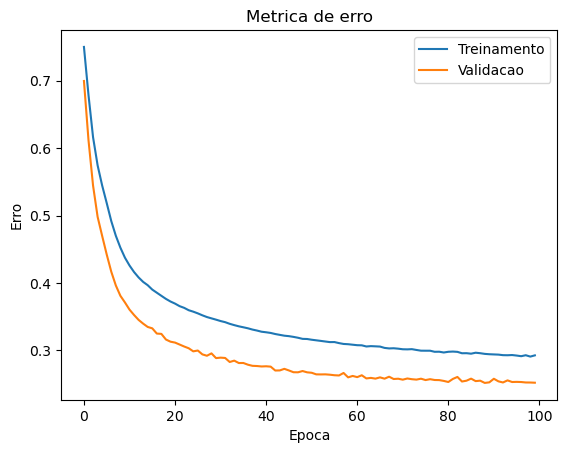

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

--> Acuracia (treino): 0.8933
--> Acuracia (validacao): 0.8989
--> acc_train - acc_val = -0.0056
--> E_val - E_in = -0.0406


In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento', 'Validacao'])
plt.show()

pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

acc_train = accuracy_score(y_train, pred_train.round())
acc_val = accuracy_score(y_val, pred_val.round())

print(f'\n--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (validacao): {acc_val:.4f}')
print(f"--> acc_train - acc_val = {acc_train - acc_val:.4f}")
print(f"--> E_val - E_in = {(history.history['val_loss'][-1] - history.history['loss'][-1]):.4f}")

Não houve overfitting. Como podemos ver não há "Boca de Jacaré".

- Justificar as escolhas para os parâmetros batch size e o número de épocas;

**Número de épocas:** Não houve necessidade de determinar um valor fora do padrão (50 ou 100).

**Batch size:** Não houve uma heurística específica, foi escolhido um valor visando menos custo computacional.

In [20]:
pass

- Computar  as  métricas  de  qualidade  da  melhor  rede  construída (acurácia,  precisão, recall, f1 score)

In [21]:
# métricas de avaliação
y_pred = model.predict(X_test)
y_pred = y_pred.round()

print(classification_report(y_test, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93       193
         1.0       0.68      0.62      0.65        42

    accuracy                           0.88       235
   macro avg       0.80      0.78      0.79       235
weighted avg       0.88      0.88      0.88       235



# 3. Construção do modelo de Árvore de Decisão

- Construir uma árvore de decisão com a instância de treino;



In [20]:
X = df.drop(columns=exclude + ['desempenho_aluno_cat'])
y = df['desempenho_aluno_cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

- Plotar a árvore e computar $𝐸_{in}$ e  $𝐸_{out}$ para analisar a existência de overfitting;

Ein: 0.0000
Eout: 0.1064


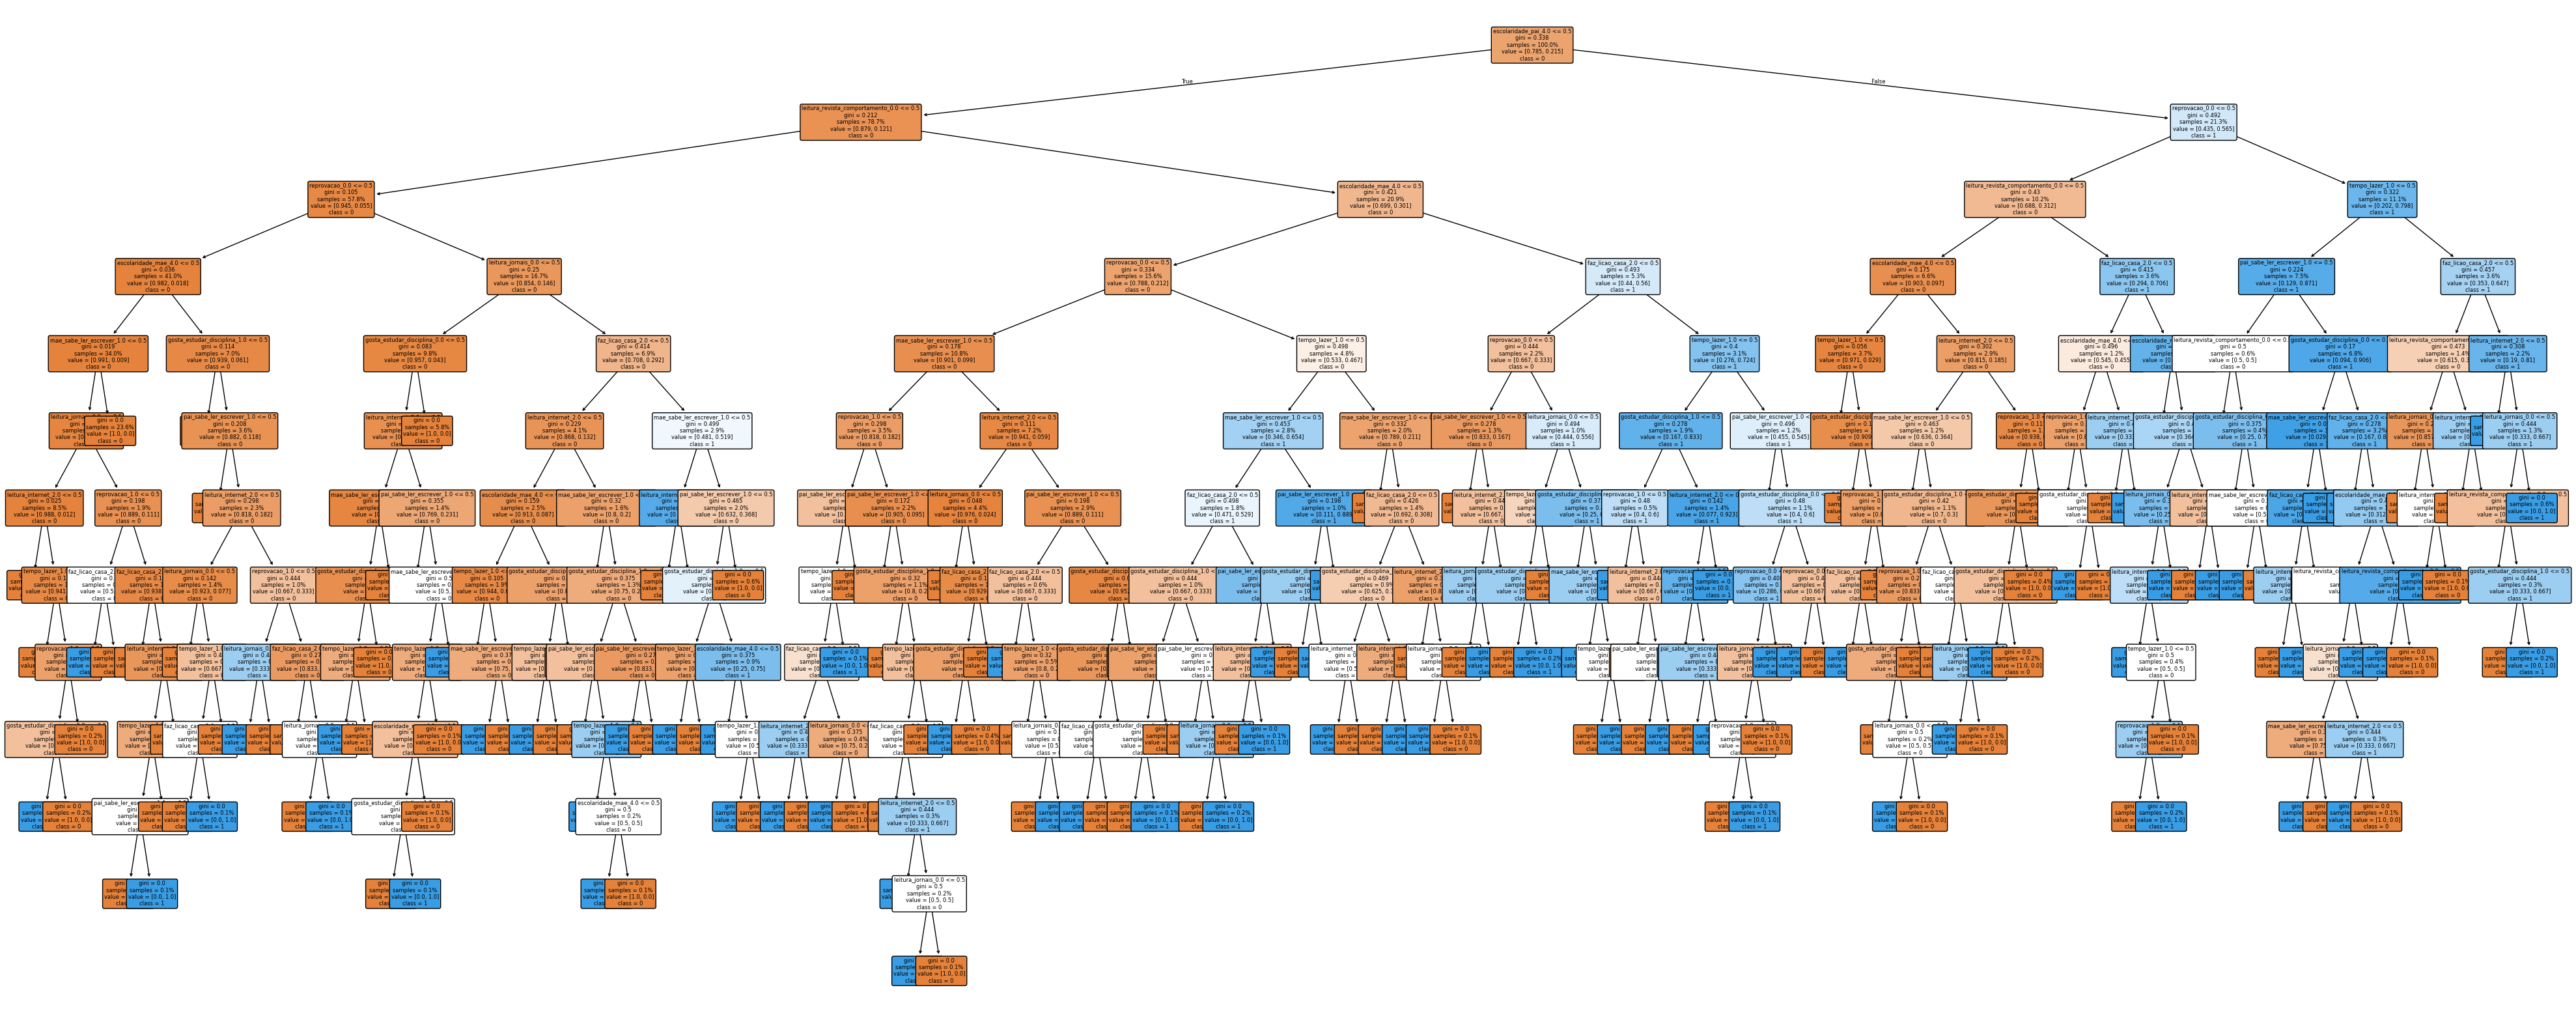

In [30]:
print('Ein: %0.4f' % (1 - accuracy_score(y_train, clf.predict(X_train))))
print('Eout: %0.4f' % (1 - accuracy_score(y_test, clf.predict(X_test))))

# feature labels
features_label = X.columns

# class label
class_label = ['0', '1']

plt.figure(figsize=(50,20))
plot_tree(
    clf,
    feature_names = features_label,
    class_names = class_label,
    filled=True,
    proportion = True,
    fontsize=6,
    rounded = True)
plt.show()

Nesse caso, podemos observar que houve overfitting, visto que a diferença entre o Ein e o Eout é significativa

- Regularizar o valor de 𝛼 utilizando o algoritmo de Minimal Cost-Complexity já
implementado na classe DecisionTreeClassifier, para encontrar a árvore que
minimize a relação:  

$$𝑃𝑢𝑟𝑒𝑧𝑎(𝑇)+ 𝛼 ∙\#𝑓𝑜𝑙ℎ𝑎𝑠(𝑇).$$

Esse processo deve ser realizado com a técnica de cross validation, onde o tamanho do fold deve ser definido pela dimensão do conjunto de treino;

In [31]:
import warnings
warnings.filterwarnings('ignore')

results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train, y_train)

alphas = path.ccp_alphas
alphas = alphas[:-1]

clfs = []
for alpha in alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    scores = cross_val_score(clf, X, y, cv=kf)
    results[alpha] = scores.mean()

best_alpha = max(results, key=results.get)
best_score = results[best_alpha]

print(f'Best Alpha: {best_alpha}, Best Score: {best_score}')

Best Alpha: 0.0010465035937320306, Best Score: 0.8883251500272777


O valor de folds foi escolhido levando em consideração o tamanho dos dados de treino, que pode ser considerado relativamente grande. Nesse caso, é recomendado o uso de 5 a 10 folds. Além disso, considerou-se o custo computacional, quanto mais folds, maior o custo, logo optamos por utilizar 5 folds.

- Plotar  a  imagem  e  computar  as  métricas  de  qualidade  da  melhor  árvore
construída.

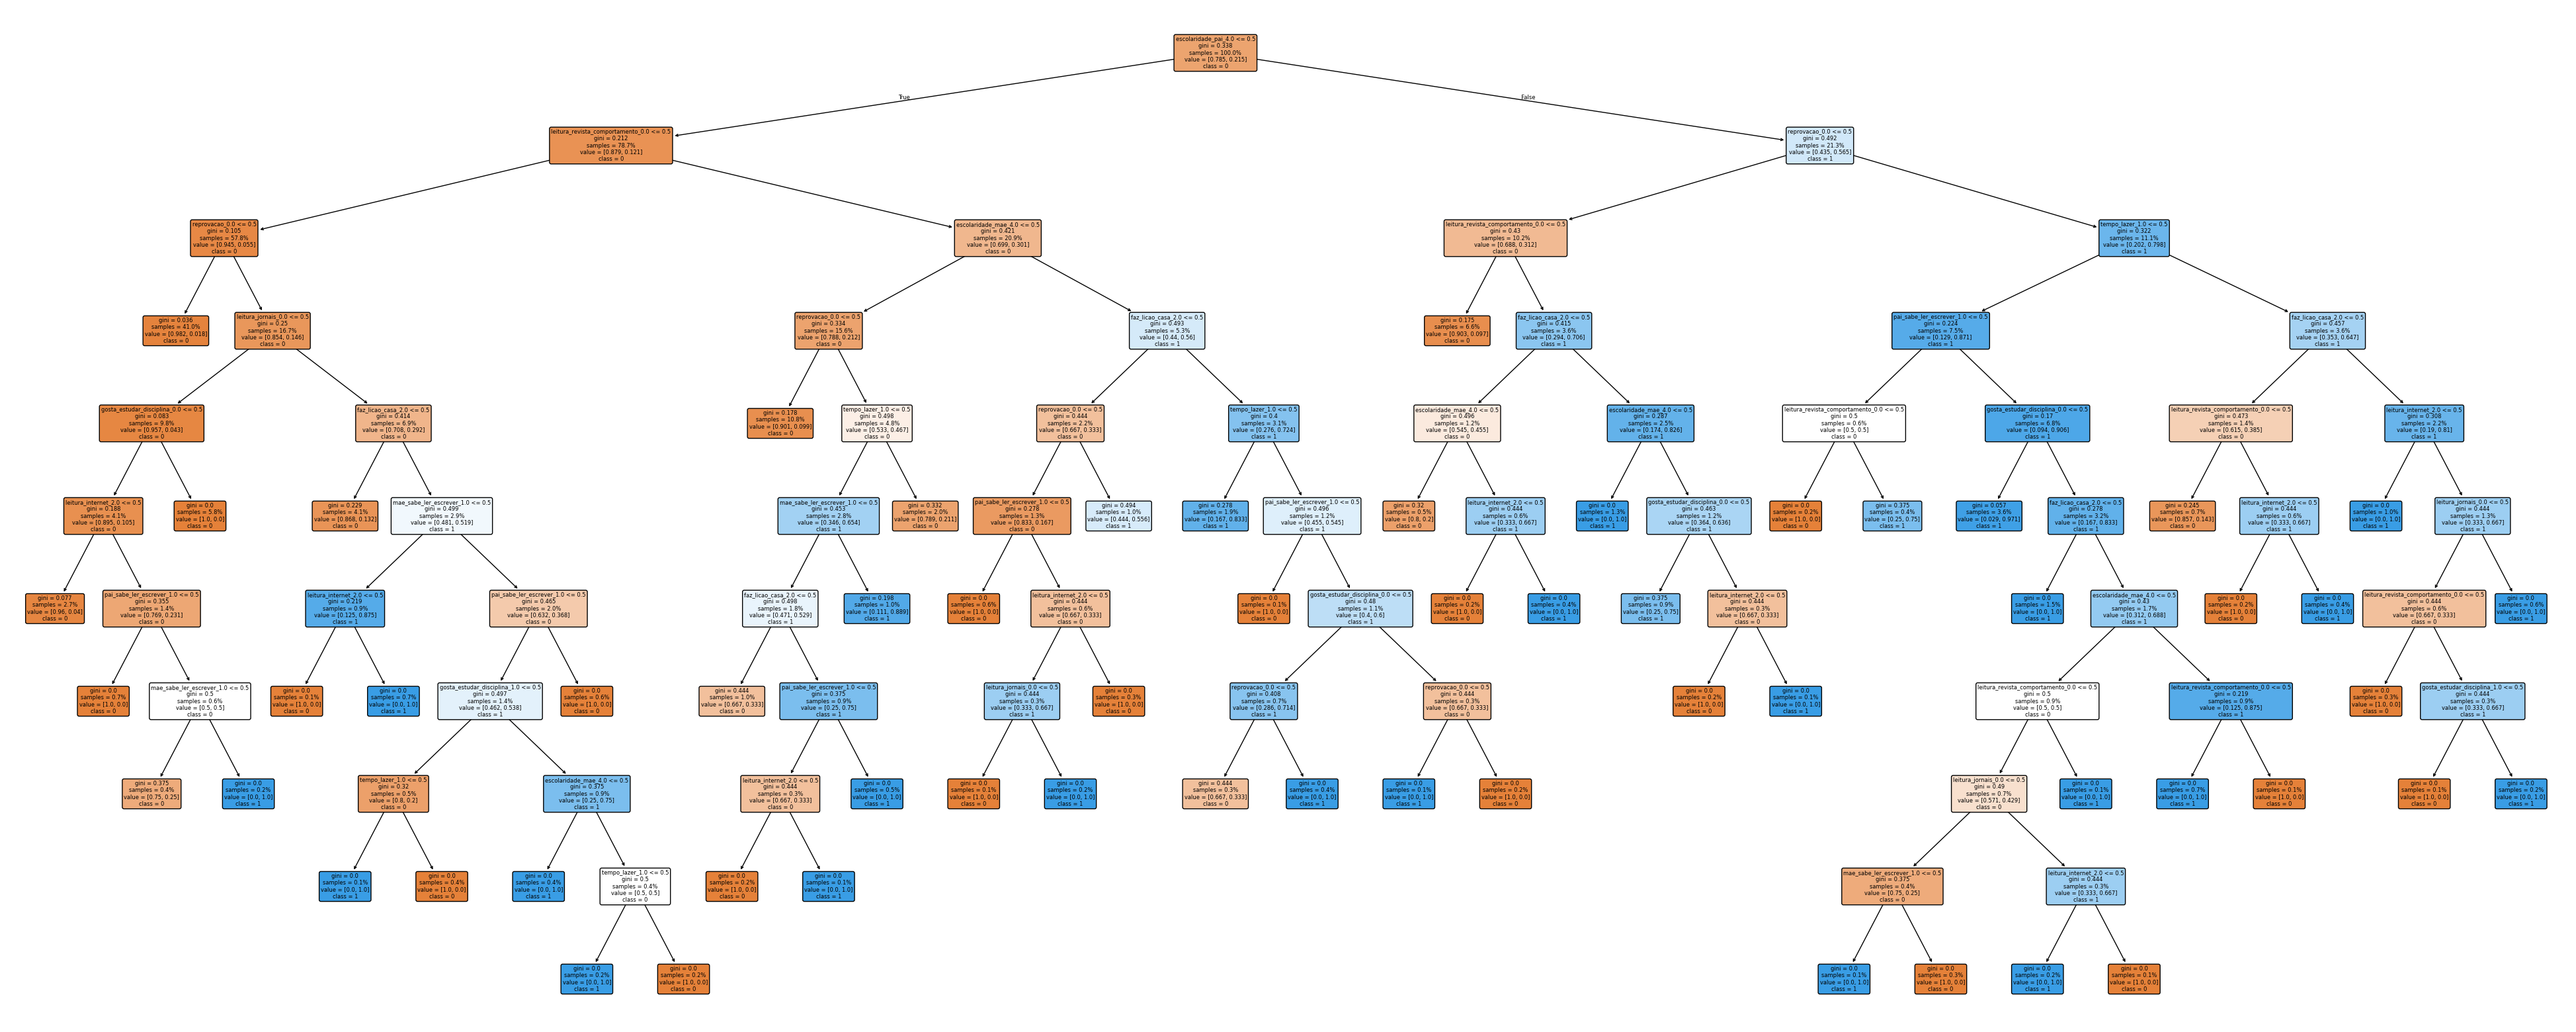

Ein: 0.0554
Eout: 0.0979
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       193
           1       0.76      0.67      0.71        42

    accuracy                           0.90       235
   macro avg       0.84      0.81      0.83       235
weighted avg       0.90      0.90      0.90       235



<Figure size 640x480 with 0 Axes>

In [32]:
best_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
best_clf.fit(X_train, y_train)

plt.figure(figsize=(50,20))
plot_tree(
    best_clf,
    feature_names = features_label,
    class_names = class_label,
    filled=True,
    proportion = True,
    fontsize=6,
    rounded = True)
plt.show()
#plt.savefig('tree.png')

print('Ein: %0.4f' % (1 - accuracy_score(y_train, best_clf.predict(X_train))))
print('Eout: %0.4f' % (1 - accuracy_score(y_test, best_clf.predict(X_test))))
print(classification_report(y_test, best_clf.predict(X_test)))

# 4. Construção do modelo SVM

- Construir um modelo de SVM, regularizando dos parâmetros 𝐶 e 𝛾 (gama) através
de cross validation, onde o tamanho do fold deve ser definido pela dimensão do
conjunto de treino;

In [33]:
X = df.drop(columns=exclude + ['desempenho_aluno_cat'])
y = df['desempenho_aluno_cat']

X = X.astype(int)
y = y.astype(int)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
param_grid = {
    'C': [0.1, 1, 5, 10, 50, 100, 200, 500],
    'gamma': [1e-5, 1e-4, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
    'kernel': ['linear', 'rbf', 'poly']
}
grid = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=param_grid, cv=5, verbose=1)

%time grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
CPU times: user 18.3 s, sys: 1.33 ms, total: 18.3 s
Wall time: 18.3 s
{'C': 500, 'gamma': 0.05, 'kernel': 'poly'}


In [38]:
clf = SVC(kernel='poly', gamma=0.05, C=500)
clf.fit(X_train, y_train)

SVC(C=500, gamma=0.05, kernel='poly')

- Computar o valor de $𝐸_{in}$,  $𝐸_{out}$ e o valor de $𝐸_{out}$ esperado, baseado no número de vetores de suporte utilizados na solução, para analisar a existência de overfitting;

In [39]:
print(X_train.shape)

# computando Ein, Eout e o valor de Eout esperado
y_pred_train = clf.predict(X_train)

Ein = 1 - accuracy_score(y_train, y_pred_train)
Eout = 1 - accuracy_score(y_test, y_pred)

print(f'Ein: {Ein:.2f}')
print(f'Eout: {Eout:.2f}')

print()
# calculando Eout esperado
n_support_vectors = len(clf.support_)
n_samples = len(X_train)

print(f'Número de vetores de suporte: {n_support_vectors}')

Eout_expected = Ein + (n_support_vectors / n_samples)

print(f'Eout esperado: {Eout_expected:.2f}')

(938, 13)
Ein: 0.05
Eout: 0.13

Número de vetores de suporte: 257
Eout esperado: 0.33


- Computar  as  métricas  de  qualidade  de  classificação  do  melhor  modelo
encontrado

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       193
           1       0.65      0.62      0.63        42

    accuracy                           0.87       235
   macro avg       0.78      0.77      0.78       235
weighted avg       0.87      0.87      0.87       235

